In [19]:
# Importy bibliotek
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns; sns.set()

import matplotlib.pylab as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Pliki CSV umieszczone w folderze data
uczestnicy = pd.read_csv('data/PPK_Uczestnicy.csv', sep=';')
pracodawcy = pd.read_csv('data/PPK_Pracodawcy.csv',sep=';')

# Mergowanie dwóch csv
df = pd.merge(
    uczestnicy,
    pracodawcy,
    how='left',
    left_on='EMPL_ID',
    right_on='ID'
)
df.info()
cp = df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1793211 entries, 0 to 1793210
Data columns (total 27 columns):
 #   Column            Dtype  
---  ------            -----  
 0   IS_SUSPENDED      int64  
 1   MEMBER_ID         int64  
 2   EMPL_ID           int64  
 3   SEX               object 
 4   NATIONALITY       int64  
 5   WORK_START        object 
 6   WORK_STOP         object 
 7   PPK_BANK          int64  
 8   AGE               object 
 9   CREATED_AT        object 
 10  NUMERICAL_VALUE   object 
 11  UOZ_START_DATE    object 
 12  UOP_SIGN_DATE     object 
 13  SIGN_DATE         object 
 14  RESIGN_DATE       object 
 15  HAS_AE            int64  
 16  HAS_AW            int64  
 17  HAS_IP            int64  
 18  ID                int64  
 19  PPK_STAGE         int64  
 20  LOGICAL_FACTOR_1  bool   
 21  REGION_CODE       object 
 22  LOGICAL_FACTOR_2  bool   
 23  VOIVODESHIP       object 
 24  PKD_CODE          float64
 25  COMPANY_SIZE      object 
 26  COMPANY_TYPE  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1793211 entries, 0 to 1793210
Data columns (total 14 columns):
 #   Column        Dtype  
---  ------        -----  
 0   IS_SUSPENDED  int64  
 1   SEX           object 
 2   NATIONALITY   int64  
 3   AGE           int64  
 4   HAS_AE        int64  
 5   HAS_AW        int64  
 6   HAS_IP        int64  
 7   PPK_STAGE     int64  
 8   VOIVODESHIP   object 
 9   COMPANY_SIZE  object 
 10  COMPANY_TYPE  float64
 11  AGE_BOX       int64  
 12  DURATION      int64  
 13  RESIGNED      bool   
dtypes: bool(1), float64(1), int64(9), object(3)
memory usage: 193.2+ MB
None
       IS_SUSPENDED   NATIONALITY           AGE        HAS_AE        HAS_AW  \
count  1.793211e+06  1.793211e+06  1.793211e+06  1.793211e+06  1.793211e+06   
mean   1.743610e-01  1.840127e+02  6.330881e+01  1.915502e-02  9.639691e-03   
std    3.794197e-01  1.526178e+01  1.437759e+01  1.370698e-01  9.770759e-02   
min    0.000000e+00  1.000000e+00  3.300000e+01  0.000000e+00

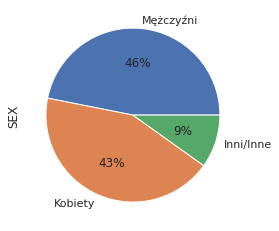

In [20]:
# cp to kopia przeczytana
df = cp


po_plci = df.SEX.value_counts(sort=True)
po_plci.plot.pie(subplots=True, autopct="%d%%", labels=["Mężczyźni","Kobiety","Inni/Inne"])
#Age to int

def to_int(age):
    age = age[:age.find(",")]
    return int(age)


df["AGE"] = df["AGE"].apply(to_int)
#dziele na pudelka z [30,40) itp
def to_box(age):
    return (age//10) * 10
df["AGE_BOX"] = df["AGE"].apply(to_box)
# Dropowanie niepotrzebnych kolumn
df.drop(columns=['MEMBER_ID','EMPL_ID', 'WORK_START', 'WORK_STOP', 'LOGICAL_FACTOR_1','LOGICAL_FACTOR_2','ID','PKD_CODE','PPK_BANK','NUMERICAL_VALUE'], inplace=True)
# zamian danych kategorycznych na dummy variables - tworzymy nową kolumnę na każdy możliwy output kolumny, porównaj poprzednią i następną komórkę
cp2 = df['SEX']

# df = pd.get_dummies(df, columns = ['SEX', 'COMPANY_SIZE', 'COMPANY_TYPE', 'VOIVODESHIP'], prefix = ['SEX', 'COMPANY_SIZE', 'COMPANY_TYPE', 'VOIVODESHIP'])
# df['SEX'] = cp2

# find duration of sign itp
def find_period(data):
    start, stop = data
    if type(stop) is float:
        stop = datetime.now().strftime("%Y-%m-%d")
    
    start_year, start_month, start_day = map(int, start.split('-'))
    stop_year, stop_month, stop_day = map(int, stop.split('-'))
    
    days = (stop_year - start_year)*365
    days += (stop_month - start_month)*30 if stop_month > start_month else (start_month - stop_month)*30
    days += stop_day - start_day if stop_day > start_day else start_day - stop_day
    
    return days


df['DURATION'] = list(zip(df['CREATED_AT'], df['RESIGN_DATE']))

df['DURATION'] = df['DURATION'].apply(find_period) 

df['RESIGNED'] = ~df['RESIGN_DATE'].isna()

df.drop(columns = ['SIGN_DATE', 'RESIGN_DATE'], inplace=True)
# z tym nie wiem co mam zrobic, mozna wyjebac albo cos mądrego zrobic
df.drop(columns=["CREATED_AT", "UOZ_START_DATE", "UOP_SIGN_DATE", 'REGION_CODE'], inplace=True)
print(df.info())
print(df.describe())

In [21]:
# Grouping other nationalities into one category '0'
unique_nat = df['NATIONALITY'].unique()

# df.loc[df.NATIONALITY != 187, 'NATIONALITY'] = 0
for val in unique_nat:
    suma = ( df['NATIONALITY'].values == val ).sum()
    if suma < 1000:
        df.loc[df.NATIONALITY == val, 'NATIONALITY'] = 0

In [22]:
df['NATIONALITY'].value_counts(sort=True)
df.shape

(1793211, 14)

/home/kacper/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/kacper/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/kacper/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn

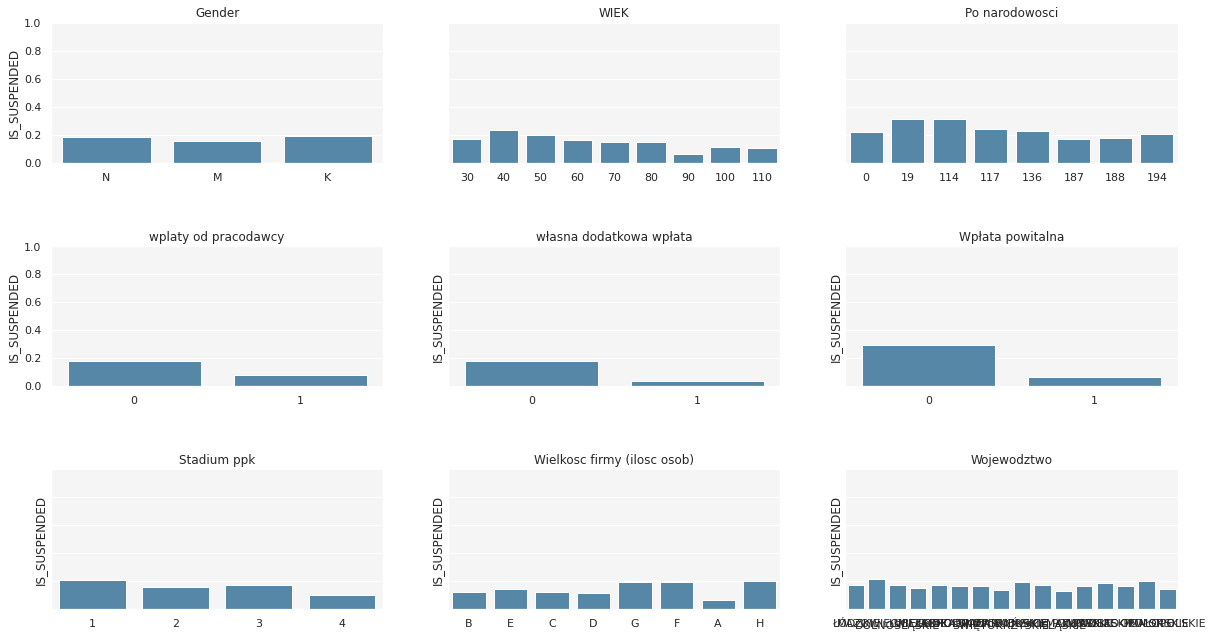

In [29]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(18,10))

sns.barplot(df['SEX'], df['IS_SUSPENDED'], color='#488ab5', ci=None, ax=ax[0][0])
ax[0][0].set_facecolor('#f5f5f5')
ax[0][0].set_ylim(0,1)
ax[0][0].set_xlabel(None)
ax[0][0].set_title('Gender')

sns.barplot(df['AGE_BOX'], df['IS_SUSPENDED'], color='#488ab5', ci=None, ax=ax[0][1])
ax[0][1].set_facecolor('#f5f5f5')
ax[0][1].tick_params(labelleft=False)
ax[0][1].set_ylim(0,1)
ax[0][1].set_ylabel(None)
ax[0][1].set_xlabel(None)
ax[0][1].set_title('WIEK')

sns.barplot(df['NATIONALITY'], df['IS_SUSPENDED'], color='#488ab5', ci=None, ax=ax[0][2])
ax[0][2].set_facecolor('#f5f5f5')
ax[0][2].tick_params(labelleft=False)
ax[0][2].set_ylim(0,1)
ax[0][2].set_ylabel(None)
ax[0][2].set_xlabel(None)
ax[0][2].set_title('Po narodowosci')

# HAS\_AE - Czy pracownik otrzymuje wpłatę dodatkową od pracodawcy?
sns.barplot(df['HAS_AE'], df['IS_SUSPENDED'], color='#488ab5', ci=None, ax=ax[1][0])
ax[1][0].set_facecolor('#f5f5f5')
ax[1][0].set_ylim(0,1)
ax[1][0].set_xlabel(None)
ax[1][0].set_title('wplaty od pracodawcy')

# HAS\_AW - Czy pracownik wpłaca własną dodatkową wpłatę?
sns.barplot(df['HAS_AW'], df['IS_SUSPENDED'], color='#488ab5', ci=None, ax=ax[1][1])
ax[1][1].set_facecolor('#f5f5f5')
ax[1][1].tick_params(labelleft=False)
ax[1][1].set_ylim(0,1)
ax[1][1].set_xlabel(None)
ax[1][1].set_title('własna dodatkowa wpłata')

# HAS\_IP - Czy pracownik otrzymał wpłatę powitalną?
sns.barplot(df['HAS_IP'], df['IS_SUSPENDED'], color='#488ab5', ci=None, ax=ax[1][2])
ax[1][2].set_facecolor('#f5f5f5')
ax[1][2].tick_params(labelleft=False)
ax[1][2].set_ylim(0,1)
ax[1][2].set_xlabel(None)
ax[1][2].set_title('Wpłata powitalna')

# PPK\_STAGE - w ktorym stadium pkk dolaczyl
sns.barplot(df['PPK_STAGE'], df['IS_SUSPENDED'], color='#488ab5', ci=None, ax=ax[2][0])
ax[2][0].set_facecolor('#f5f5f5')
ax[2][0].tick_params(labelleft=False)
ax[2][0].set_ylim(0,1)
ax[2][0].set_xlabel(None)
ax[2][0].set_title('Stadium ppk')

#COMPANY\_SIZE\_A - do 10 pracownikow
sns.barplot(df['COMPANY_SIZE'], df['IS_SUSPENDED'], color='#488ab5', ci=None, ax=ax[2][1])
ax[2][1].set_facecolor('#f5f5f5')
ax[2][1].tick_params(labelleft=False)
ax[2][1].set_ylim(0,1)
ax[2][1].set_xlabel(None)
ax[2][1].set_title('Wielkosc firmy (ilosc osob)')

#VOVOIDESHIP
sns.barplot(df['VOIVODESHIP'], df['IS_SUSPENDED'], color='#488ab5', ci=None, ax=ax[2][2])
ax[2][2].set_facecolor('#f5f5f5')
ax[2][2].tick_params(labelleft=False)
ax[2][2].set_ylim(0,1)
ax[2][2].set_xlabel(None)
ax[2][2].set_title('Wojewodztwo')

plt.tight_layout(pad=4.0)


In [24]:
print(df.loc[df.NATIONALITY, 'NATIONALITY'].count())
ilosc = df.loc[df.NATIONALITY, 'NATIONALITY'].count()
# Grouping other nationalities into one category '0'


# df.loc[df.NATIONALITY != 187, 'NATIONALITY'] = 0
for val in unique_nat:
    suma = ( df['NATIONALITY'].values == val ).sum()
    if suma < 1000:
        df.loc[df.NATIONALITY == val, 'NATIONALITY'] = 0

1793211
